# Koopman kernel models for TC Tracks

[Work in progress]

In [5]:
# %matplotlib inline
from klearn_tcyclone.climada.tc_tracks import TCTracks
import numpy as np
from itertools import product

import matplotlib.pyplot as plt
from klearn_tcyclone.data_utils import context_dataset_from_TCTracks

from sklearn.model_selection import train_test_split
from klearn_tcyclone.data_utils import characteristic_length_scale_from_TCTracks
from kooplearn.models import Kernel, NystroemKernel
from sklearn.gaussian_process.kernels import RBF
from klearn_tcyclone.performance_benchmark import timer
from klearn_tcyclone.data_utils import standardize_TensorContextDataset, LinearScaler

from kooplearn.models import Kernel, NystroemKernel

from klearn_tcyclone.performance_benchmark import timer
from klearn_tcyclone.models_utils import predict_time_series

from kooplearn.utils import topk

from klearn_tcyclone.climada.tc_tracks_tools import BASINS

### Get data and preprocess

In [37]:
tc_tracks = TCTracks.from_ibtracs_netcdf(provider='usa', year_range=(2000, 2011), basin='NA', correct_pres=False)
print('Number of tracks:', tc_tracks.size)

2024-11-16 07:54:36,433 - climada.hazard.tc_tracks - WARNING - The cached IBTrACS data set dates from 2023-06-07 23:07:38 (older than 180 days). Very likely, a more recent version is available. Consider manually removing the file C:\Users\Eric\climada\data\IBTrACS.ALL.v04r00.nc and re-running this function, which will download the most recent version of the IBTrACS data set from the official URL.


c:\Users\Eric\Projects\koopman_learning_tropical_cyclone\.venv\Lib\site-packages\climada\hazard\tc_tracks.py:614: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if ibtracs_ds.dims['storm'] == 0:


Number of tracks: 214


In [30]:
tc_tracks2 = TCTracks.from_ibtracs_netcdf(provider='official', year_range=(2000, 2011), basin='SA', correct_pres=False)
print('Number of tracks:', tc_tracks.size)

2024-11-16 07:54:01,139 - climada.hazard.tc_tracks - WARNING - The cached IBTrACS data set dates from 2023-06-07 23:07:38 (older than 180 days). Very likely, a more recent version is available. Consider manually removing the file C:\Users\Eric\climada\data\IBTrACS.ALL.v04r00.nc and re-running this function, which will download the most recent version of the IBTrACS data set from the official URL.
Number of tracks: 214


c:\Users\Eric\Projects\koopman_learning_tropical_cyclone\.venv\Lib\site-packages\climada\hazard\tc_tracks.py:614: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if ibtracs_ds.dims['storm'] == 0:


In [38]:
from klearn_tcyclone.utils import check_time_steps_TCTracks

In [41]:
tc_tracks.equal_timestep(time_step_h=3)

In [42]:
check_time_steps_TCTracks(tc_tracks, time_step_h=3)

np.True_

In [14]:
len(tc_tracks.data)

214

In [27]:
tc_tracks2.equal_timestep(time_step_h=2)

In [28]:
len(tc_tracks2.data)

3

In [29]:
tc_tracks2.data[2]

<xarray.Dataset> Size: 7kB
Dimensions:                 (time: 85)
Coordinates:
  * time                    (time) datetime64[ns] 680B 2011-03-09T18:00:00 .....
    lon                     (time) float64 680B -39.0 -39.03 ... -31.0 -30.5
    lat                     (time) float64 680B -19.7 -19.78 ... -25.51 -25.4
Data variables:
    radius_max_wind         (time) float64 680B 0.0 0.0 0.0 ... 100.0 66.67 0.0
    radius_oci              (time) float64 680B 0.0 0.0 0.0 ... 150.0 100.0 0.0
    max_sustained_wind      (time) float64 680B 20.0 20.0 20.0 ... 45.0 45.0
    central_pressure        (time) float64 680B 1.007e+03 1.008e+03 ... 989.0
    environmental_pressure  (time) float64 680B 1.01e+03 1.01e+03 ... 1.005e+03
    time_step               (time) float64 680B 2.0 2.0 2.0 2.0 ... 2.0 2.0 2.0
    basin                   (time) <U2 680B 'SA' 'SA' 'SA' ... 'SA' 'SA' 'SA'
Attributes:
    max_sustained_wind_unit:  kn
    central_pressure_unit:    mb
    orig_event_flag:          True
    data_provider:            ibtracs_official
    category:                 0
    name:                     NOT_NAMED
    sid:                      2011069S20321
    id_no:                    2011069120321.0

In [ ]:
tc_tracks = TCTracks.from_ibtracs_netcdf(provider='usa', year_range=(2000, 2021), basin='NA', correct_pres=False)
print('Number of tracks:', tc_tracks.size)

c:\Users\Eric\Projects\koopman_learning_tropical_cyclone\.venv\Lib\site-packages\xarray\backends\plugins.py:75: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


2024-11-15 20:32:08,530 - climada.hazard.tc_tracks - WARNING - The cached IBTrACS data set dates from 2023-06-07 23:07:38 (older than 180 days). Very likely, a more recent version is available. Consider manually removing the file C:\Users\Eric\climada\data\IBTrACS.ALL.v04r00.nc and re-running this function, which will download the most recent version of the IBTrACS data set from the official URL.


c:\Users\Eric\Projects\koopman_learning_tropical_cyclone\.venv\Lib\site-packages\climada\hazard\tc_tracks.py:614: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if ibtracs_ds.dims['storm'] == 0:


Number of tracks: 393


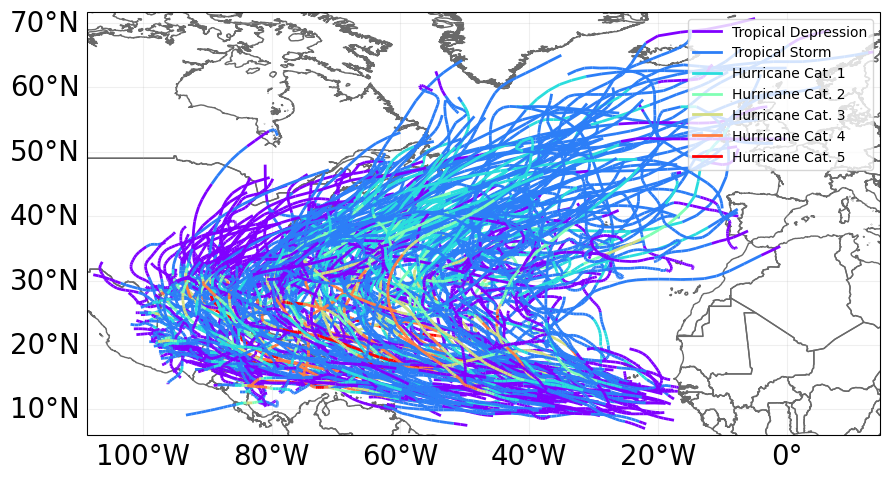

In [3]:
ax = tc_tracks.plot()

### Normalise data

In [5]:
tc_tracks_train, tc_tracks_test = train_test_split(tc_tracks.data, test_size=0.1)

context_length = 2
feature_list = ["lat", "lon", "max_sustained_wind"]
# feature_list = ["lat", "lon", "max_sustained_wind", "central_pressure"]
tensor_context_train = context_dataset_from_TCTracks(
    tc_tracks_train, feature_list=feature_list, context_length=context_length
)
tensor_context_test = context_dataset_from_TCTracks(
    tc_tracks_test, feature_list=feature_list, context_length=context_length
)

contexts = {
    "train": tensor_context_train,
    "test": tensor_context_test,
}

In [6]:
contexts["train"].shape

(20038, 2, 3)

In [7]:
# scaler = StandardScaler()
scaler = LinearScaler()
# scaler = MinMaxScaler()
tensor_context_train_transformed = standardize_TensorContextDataset(
    tensor_context_train,
    scaler,
    fit=True,
)
tensor_context_test_transformed = standardize_TensorContextDataset(
    tensor_context_test,
    scaler,
    fit=False,
)

contexts = {
    "train": tensor_context_train_transformed,
    "test": tensor_context_test_transformed,
}

for split, ds in contexts.items():
    print(f"{split.capitalize()} contexts have shape {ds.shape}: {len(ds)} contexts of length {ds.context_length} with {ds.shape[2]} features each")

Train contexts have shape (20038, 2, 3): 20038 contexts of length 2 with 3 features each
Test contexts have shape (2284, 2, 3): 2284 contexts of length 2 with 3 features each


### Spectral analysis

In [8]:
reduced_rank = True
rank = 25
num_centers = 250
tikhonov_reg = 1e-6

# Instantiang the RBF kernel and its length scale as the median of the pairwise distances of the dataset
length_scale = characteristic_length_scale_from_TCTracks(tc_tracks_train, feature_list, quantile=0.2)
length_scale = 50.0
print("Length scale:", length_scale)
kernel = RBF(length_scale=length_scale)

model = NystroemKernel(kernel=kernel, reduced_rank=reduced_rank, svd_solver='arnoldi', tikhonov_reg=tikhonov_reg, rank = rank, num_centers=num_centers, rng_seed=42)

Length scale: 50.0


In [9]:
model = model.fit(contexts["train"])

The rank attribute has been updated to 7.
Consider decreasing the rank parameter.


#### Plot eigenvalues

In [9]:
eig = model.eig()

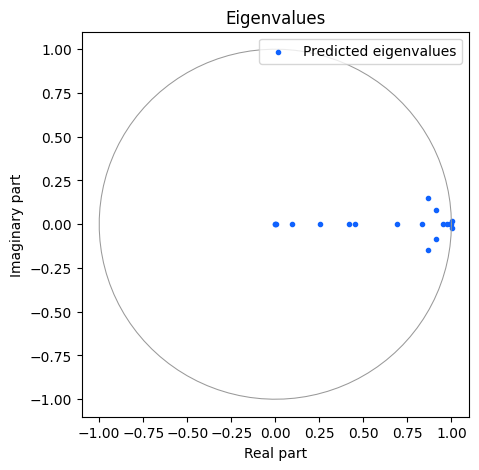

In [10]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(5, 5))

ax.scatter(eig.real, eig.imag, label='Predicted eigenvalues', marker = '.', color='#0f62fe')
# Plot unit circle
theta = np.linspace(0, 2*np.pi, 100)
ax.plot(np.cos(theta), np.sin(theta), linestyle='-', color='#999', lw=0.75)
ax.set_xlabel('Real part')
ax.set_ylabel('Imaginary part')
ax.set_title('Eigenvalues')
ax.legend(loc=1)
plt.show()

#### Scaling of time scales

In [3]:
# def train_model(time_lag: int, subsample: int):
#     tr_dist_ctx, ts_dist_ctx, _ = build_contexts(time_lag, subsample)
#     kernel = RBF(length_scale=0.5)
#     nys_rrr = NystroemKernel(
#         kernel=kernel,
#         reduced_rank=True,  # Set the estimator to RRR. If False the estimator is PCR.
#         tikhonov_reg=1e-7,
#         rank=5,
#         num_centers=300, 
#         rng_seed=0
#     )
    
#     nys_rrr.fit(tr_dist_ctx)
    
#     X_pred = nys_rrr.predict(ts_dist_ctx)  # Here we must pass the `X` part of the context
#     X_true = ts_dist_ctx.lookforward(nys_rrr.lookback_len)# This is the `Y` part of the test context
#     rmse_onestep = np.sqrt(np.mean((X_pred - X_true)**2))

#     evals = nys_rrr.eig()
#     evals = evals[topk(np.abs(evals), 4).indices]

#     tscales = -1 / np.log(evals.real.clip(1e-8, 1))
#     tscales_real = tscales * time_lag
    
#     return rmse_onestep, tscales_real

In [183]:
def train_model(tc_tracks_train, tc_tracks_test, context_length, time_lag, feature_list = ["lat", "lon", "max_sustained_wind"], top_k: int = 7):


    tensor_context_train = context_dataset_from_TCTracks(
        tc_tracks_train, feature_list=feature_list, context_length=context_length, time_lag=time_lag,
    )
    tensor_context_test = context_dataset_from_TCTracks(
        tc_tracks_test, feature_list=feature_list, context_length=context_length, time_lag=time_lag,
    )
    contexts = {
        "train": tensor_context_train,
        "test": tensor_context_test,
    }
    scaler = LinearScaler()
    tensor_context_train_transformed = standardize_TensorContextDataset(
        tensor_context_train,
        scaler,
        fit=True,
    )
    tensor_context_test_transformed = standardize_TensorContextDataset(
        tensor_context_test,
        scaler,
        fit=False,
    )

    contexts = {
        "train": tensor_context_train_transformed,
        "test": tensor_context_test_transformed,
    }


    ### Spectral analysis
    reduced_rank = True
    rank = 50
    num_centers = 300
    tikhonov_reg = 1e-4

    # Instantiang the RBF kernel and its length scale as the median of the pairwise distances of the dataset
    length_scale = 10.0
    kernel = RBF(length_scale=length_scale)
    nys_rrr = NystroemKernel(kernel=kernel, reduced_rank=reduced_rank, svd_solver='arnoldi', tikhonov_reg=tikhonov_reg, rank = rank, num_centers=num_centers, rng_seed=42)
    nys_rrr = nys_rrr.fit(contexts["train"])


    X_pred = nys_rrr.predict(contexts["test"])  # Here we must pass the `X` part of the context
    X_true = contexts["test"].lookforward(nys_rrr.lookback_len)# This is the `Y` part of the test context
    rmse_onestep = np.sqrt(np.mean((X_pred - X_true)**2))

    evals = nys_rrr.eig()
    evals = evals[topk(np.abs(evals), top_k).indices]
    
    print(evals)
    print(evals.real.clip(1e-8, 1))

    tscales = -1 / np.log(evals.real.clip(1e-6, 1))
    tscales_real = tscales * time_lag
    
    print(tscales)

    return rmse_onestep, tscales_real

In [184]:
tc_tracks_train, tc_tracks_test = train_test_split(tc_tracks.data, test_size=0.1)

In [ ]:
context_length = 5 
# with context_length = 2 it works much better.. why?

In [225]:
time_lag = 5
error, tscale = train_model(tc_tracks_train, tc_tracks_test, context_length, time_lag)

The rank attribute has been updated to 16.
Consider decreasing the rank parameter.


[0.9974547 +0.j         0.9649293 +0.03178295j 0.9649293 -0.03178295j
 0.86649194+0.j         0.48997647+0.j         0.4128544 +0.j
 0.28340484+0.j        ]
[0.9974547  0.9649293  0.9649293  0.86649194 0.48997647 0.4128544
 0.28340484]
[392.38124443  28.01085607  28.01085607   6.97824648   1.40174226
   1.13037741   0.7930976 ]


In [226]:
error_d = {}
tscale_d = {}
for time_lag in range(3, 25):
# for time_lag in [1, 2, 5, 10, 20, 50]:
    print(time_lag)
    error, tscale = train_model(tc_tracks_train, tc_tracks_test, context_length, time_lag)
    error_d[time_lag] = error
    tscale_d[time_lag] = tscale

3


The rank attribute has been updated to 18.
Consider decreasing the rank parameter.


[0.99713608+0.j         0.97515529+0.00301748j 0.97515529-0.00301748j
 0.92411106+0.j         0.53383651+0.j         0.27209409+0.j
 0.18716848+0.j        ]
[0.99713608 0.97515529 0.97515529 0.92411106 0.53383651 0.27209409
 0.18716848]
[348.67173674  39.74791657  39.74791657  12.67057534   1.59320494
   0.76828084   0.59674911]
4


The rank attribute has been updated to 17.
Consider decreasing the rank parameter.


[0.99716361+0.j         0.97200509+0.01920126j 0.97200509-0.01920126j
 0.89232262+0.j         0.5096266 +0.j         0.35674847+0.j
 0.22224324+0.j        ]
[0.99716361 0.97200509 0.97200509 0.89232262 0.5096266  0.35674847
 0.22224324]
[352.06035331  35.21841178  35.21841178   8.7775101    1.48351008
   0.97019152   0.6649012 ]
5


The rank attribute has been updated to 15.
Consider decreasing the rank parameter.


[0.99745373+0.j         0.96489675+0.03176431j 0.96489675-0.03176431j
 0.86683549+0.j         0.48823138+0.j         0.41089005+0.j
 0.28357824+0.j        ]
[0.99745373 0.96489675 0.96489675 0.86683549 0.48823138 0.41089005
 0.28357824]
[392.23065386  27.98440917  27.98440917   6.99760373   1.39476657
   1.12431605   0.79348251]
6


The rank attribute has been updated to 16.
Consider decreasing the rank parameter.


[0.99755696+0.j         0.95398552+0.0418745j  0.95398552-0.0418745j
 0.85783414+0.j         0.51148892+0.j         0.35102258+0.03537943j
 0.35102258-0.03537943j]
[0.99755696 0.95398552 0.95398552 0.85783414 0.51148892 0.35102258
 0.35102258]
[408.82578659  21.22836393  21.22836393   6.5212637    1.49158148
   0.95519676   0.95519676]
7


The rank attribute has been updated to 16.
Consider decreasing the rank parameter.


[0.99784785+0.j         0.93898187+0.06077642j 0.93898187-0.06077642j
 0.86679794+0.j         0.53733028+0.j         0.33781488+0.j
 0.23872614+0.1270671j ]
[0.99784785 0.93898187 0.93898187 0.86679794 0.53733028 0.33781488
 0.23872614]
[464.15080194  15.88332425  15.88332425   6.99548291   1.60993699
   0.92144054   0.69811037]
8


The rank attribute has been updated to 20.
Consider decreasing the rank parameter.


[0.99797264+0.j         0.9221154 +0.08615757j 0.9221154 -0.08615757j
 0.88528659+0.j         0.55141252+0.j         0.37517241+0.j
 0.24484549+0.21886983j]
[0.99797264 0.9221154  0.9221154  0.88528659 0.55141252 0.37517241
 0.24484549]
[492.75244175  12.33275203  12.33275203   8.20722524   1.67990411
   1.02002348   0.71066745]
9


The rank attribute has been updated to 16.
Consider decreasing the rank parameter.


[0.99817276+0.j         0.91217762+0.11877686j 0.91217762-0.11877686j
 0.88921393+0.j         0.55538542+0.j         0.39164303+0.j
 0.23174089+0.26933346j]
[0.99817276 0.91217762 0.91217762 0.88921393 0.55538542 0.39164303
 0.23174089]
[546.77310078  10.87896087  10.87896087   8.51662305   1.70041145
   1.06677535   0.68393119]
10


The rank attribute has been updated to 20.
Consider decreasing the rank parameter.


[0.99815215+0.j         0.89765082+0.14179751j 0.89765082-0.14179751j
 0.89348574+0.j         0.54552161+0.j         0.39906728+0.j
 0.19721286+0.24878842j]
[0.99815215 0.89765082 0.89765082 0.89348574 0.54552161 0.39906728
 0.19721286]
[540.66829581   9.26147832   9.26147832   8.87903066   1.65013001
   1.08858318   0.61596396]
11


The rank attribute has been updated to 17.
Consider decreasing the rank parameter.


[0.99813233+0.j         0.9026424 +0.j         0.88289976+0.17384311j
 0.88289976-0.17384311j 0.50542233+0.j         0.35913575+0.06526804j
 0.35913575-0.06526804j]
[0.99813233 0.9026424  0.88289976 0.88289976 0.50542233 0.35913575
 0.35913575]
[534.92660223   9.76287794   8.02931601   8.02931601   1.46550014
   0.97651021   0.97651021]
12


The rank attribute has been updated to 18.
Consider decreasing the rank parameter.


[0.99819033+0.j         0.87470539+0.19676508j 0.87470539-0.19676508j
 0.88583125+0.j         0.45056427+0.j         0.41750845+0.10988509j
 0.41750845-0.10988509j]
[0.99819033 0.87470539 0.87470539 0.88583125 0.45056427 0.41750845
 0.41750845]
[552.08648922   7.47003711   7.47003711   8.24886407   1.25430455
   1.14488458   1.14488458]
13


The rank attribute has been updated to 16.
Consider decreasing the rank parameter.


[0.99802953+0.j         0.88596792+0.j         0.8542521 +0.22186773j
 0.8542521 -0.22186773j 0.43283381+0.14011025j 0.43283381-0.14011025j
 0.44807539+0.j        ]
[0.99802953 0.88596792 0.8542521  0.8542521  0.43283381 0.43283381
 0.44807539]
[506.99338978   8.25937473   6.34804044   6.34804044   1.19417038
   1.19417038   1.2456499 ]
14


The rank attribute has been updated to 19.
Consider decreasing the rank parameter.


[0.99830398+0.j         0.84097015+0.23595821j 0.84097015-0.23595821j
 0.86316369+0.j         0.44343763+0.15014492j 0.44343763-0.15014492j
 0.41246504+0.j        ]
[0.99830398 0.84097015 0.84097015 0.86316369 0.44343763 0.44343763
 0.41246504]
[589.11696758   5.77370182   5.77370182   6.79574382   1.22971264
   1.22971264   1.12917309]
15


The rank attribute has been updated to 21.
Consider decreasing the rank parameter.


[0.99851598+0.j         0.86605387+0.j         0.81495652+0.25618806j
 0.81495652-0.25618806j 0.42468519+0.15856394j 0.42468519-0.15856394j
 0.33328276+0.j        ]
[0.99851598 0.86605387 0.81495652 0.81495652 0.42468519 0.42468519
 0.33328276]
[673.34365931   6.95370824   4.88709559   4.88709559   1.16766894
   1.16766894   0.91011353]
16


The rank attribute has been updated to 13.
Consider decreasing the rank parameter.


[0.99835789+0.j         0.89033669+0.j         0.75949936+0.25842733j
 0.75949936-0.25842733j 0.41363016+0.j         0.35866752+0.17293284j
 0.35866752-0.17293284j]
[0.99835789 0.89033669 0.75949936 0.75949936 0.41363016 0.35866752
 0.35866752]
[608.47266285   8.60914233   3.63509737   3.63509737   1.13278117
   0.97526775   0.97526775]
17


The rank attribute has been updated to 16.
Consider decreasing the rank parameter.


[0.99839151+0.j         0.89452188+0.j         0.72637546+0.28502233j
 0.72637546-0.28502233j 0.46471632+0.j         0.38434633+0.16835756j
 0.38434633-0.16835756j]
[0.99839151 0.89452188 0.72637546 0.72637546 0.46471632 0.38434633
 0.38434633]
[621.20158823   8.97135269   3.12804752   3.12804752   1.30492406
   1.04579404   1.04579404]
18


The rank attribute has been updated to 20.
Consider decreasing the rank parameter.


[0.99755841+0.j         0.92148   +0.j         0.65883643+0.312946j
 0.65883643-0.312946j   0.5150679 +0.j         0.41128927+0.j
 0.34740074+0.20107785j]
[0.99755841 0.92148    0.65883643 0.65883643 0.5150679  0.41128927
 0.34740074]
[409.06904387  12.22879459   2.39647244   2.39647244   1.50725775
   1.12554497   0.94582656]
19


The rank attribute has been updated to 13.
Consider decreasing the rank parameter.


[0.99865034+0.j         0.84029614+0.j         0.62780113+0.3045236j
 0.62780113-0.3045236j  0.55929554+0.09925656j 0.55929554-0.09925656j
 0.28369497+0.20565735j]
[0.99865034 0.84029614 0.62780113 0.62780113 0.55929554 0.55929554
 0.28369497]
[740.42618773   5.74709652   2.14808078   2.14808078   1.72094156
   1.72094156   0.79374171]
20


The rank attribute has been updated to 18.
Consider decreasing the rank parameter.


[ 0.99856701+0.j          0.83592726+0.j          0.60658216+0.36349552j
  0.60658216-0.36349552j  0.59552052+0.10581566j  0.59552052-0.10581566j
 -0.20165916-0.34236569j]
[9.98567006e-01 8.35927261e-01 6.06582158e-01 6.06582158e-01
 5.95520520e-01 5.95520520e-01 1.00000000e-08]
[6.97339608e+02 5.57993125e+00 2.00033967e+00 2.00033967e+00
 1.92931219e+00 1.92931219e+00 7.23824137e-02]
21


The rank attribute has been updated to 16.
Consider decreasing the rank parameter.


[ 0.99886849+0.j          0.78573115+0.18408017j  0.78573115-0.18408017j
  0.57404304+0.4053591j   0.57404304-0.4053591j   0.54602485+0.j
 -0.24449587-0.39852429j]
[9.98868491e-01 7.85731150e-01 7.85731150e-01 5.74043040e-01
 5.74043040e-01 5.46024850e-01 1.00000000e-08]
[8.83275122e+02 4.14695837e+00 4.14695837e+00 1.80163656e+00
 1.80163656e+00 1.65264455e+00 7.23824137e-02]
22


The rank attribute has been updated to 15.
Consider decreasing the rank parameter.


[ 0.99943613+0.j          0.80224182+0.19296292j  0.80224182-0.19296292j
  0.582847  +0.42906298j  0.582847  -0.42906298j  0.55725105+0.j
 -0.28578458+0.42343742j]
[9.99436126e-01 8.02241819e-01 8.02241819e-01 5.82847002e-01
 5.82847002e-01 5.57251046e-01 1.00000000e-08]
[1.77294557e+03 4.53833356e+00 4.53833356e+00 1.85243311e+00
 1.85243311e+00 1.71016345e+00 7.23824137e-02]
23


The rank attribute has been updated to 19.
Consider decreasing the rank parameter.


[ 0.99939419+0.j          0.76856528+0.19134853j  0.76856528-0.19134853j
  0.58300765+0.4441951j   0.58300765-0.4441951j   0.60604956+0.j
 -0.33135898+0.46455427j]
[9.99394193e-01 7.68565280e-01 7.68565280e-01 5.83007649e-01
 5.83007649e-01 6.06049556e-01 1.00000000e-08]
[1.65019064e+03 3.79896233e+00 3.79896233e+00 1.85337927e+00
 1.85337927e+00 1.99683094e+00 7.23824137e-02]
24


The rank attribute has been updated to 17.
Consider decreasing the rank parameter.


[ 0.99933081+0.j          0.80452523+0.26123968j  0.80452523-0.26123968j
  0.55312065+0.45488733j  0.55312065-0.45488733j  0.63165283+0.j
 -0.32653831+0.42388681j]
[9.99330808e-01 8.04525227e-01 8.04525227e-01 5.53120651e-01
 5.53120651e-01 6.31652828e-01 1.00000000e-08]
[1.49383882e+03 4.59763868e+00 4.59763868e+00 1.68867824e+00
 1.68867824e+00 2.17667952e+00 7.23824137e-02]


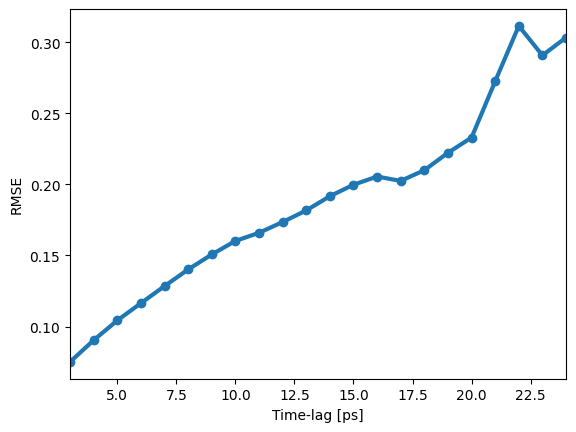

In [227]:
fig, ax = plt.subplots()
ax.plot(error_d.keys(), error_d.values(), lw=3, marker='o')
ax.set_xlabel("Time-lag [ps]")
ax.set_ylabel("RMSE")
ax.margins(x=0)

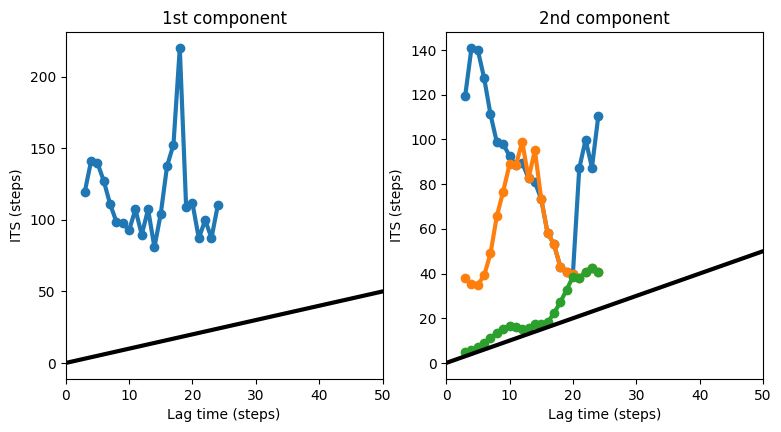

In [228]:
fig, ax = plt.subplots(ncols=2, figsize=(9, 4.5))
time_lags = list(tscale_d.keys())
ax[0].plot(time_lags, [tscale[1] for tscale in tscale_d.values()], lw=3, marker='o')
ax[1].plot(time_lags, [tscale[2] for tscale in tscale_d.values()], lw=3, marker='o')
ax[1].plot(time_lags, [tscale[3] for tscale in tscale_d.values()], lw=3, marker='o')
ax[1].plot(time_lags, [tscale[4] for tscale in tscale_d.values()], lw=3, marker='o')
ax[0].plot([0, 50], [0, 50], lw=3, c='k')
ax[1].plot([0, 50], [0, 50], lw=3, c='k')
ax[0].set_xlabel("Lag time (steps)")
ax[0].set_ylabel("ITS (steps)")
ax[1].set_xlabel("Lag time (steps)")
ax[1].set_ylabel("ITS (steps)")
ax[0].set_title("1st component")
ax[1].set_title("2nd component")
ax[0].margins(x=0)
ax[1].margins(x=0)

#### Plot eigenfunctions along trajectories

In [82]:
test_dataset = contexts["test"]

In [83]:
top_k = 42
evals, evec_right = model.eig(eval_right_on=test_dataset)
top_evals = topk(np.abs(evals), top_k) # Take the Four largest eigenvalues in modulus
evals = evals[top_evals.indices]
evec_right = evec_right[:, top_evals.indices]

In [84]:
evals.shape, evec_right.shape

((18,), (908, 18))

In [85]:
evals

array([ 0.99993099+0.j        ,  0.99810281+0.01789582j,
        0.99810281-0.01789582j,  0.99284253+0.j        ,
        0.96966378+0.j        ,  0.95157093+0.j        ,
        0.92774601+0.j        ,  0.91192916+0.11948172j,
        0.91192916-0.11948172j,  0.84056807+0.17061753j,
        0.84056807-0.17061753j,  0.80860608+0.j        ,
        0.4659339 +0.03439862j,  0.4659339 -0.03439862j,
        0.31285702+0.j        ,  0.08403348+0.j        ,
        0.01126608+0.j        , -0.00254642+0.j        ])

In [86]:
test_dataset.shape

(908, 42, 3)

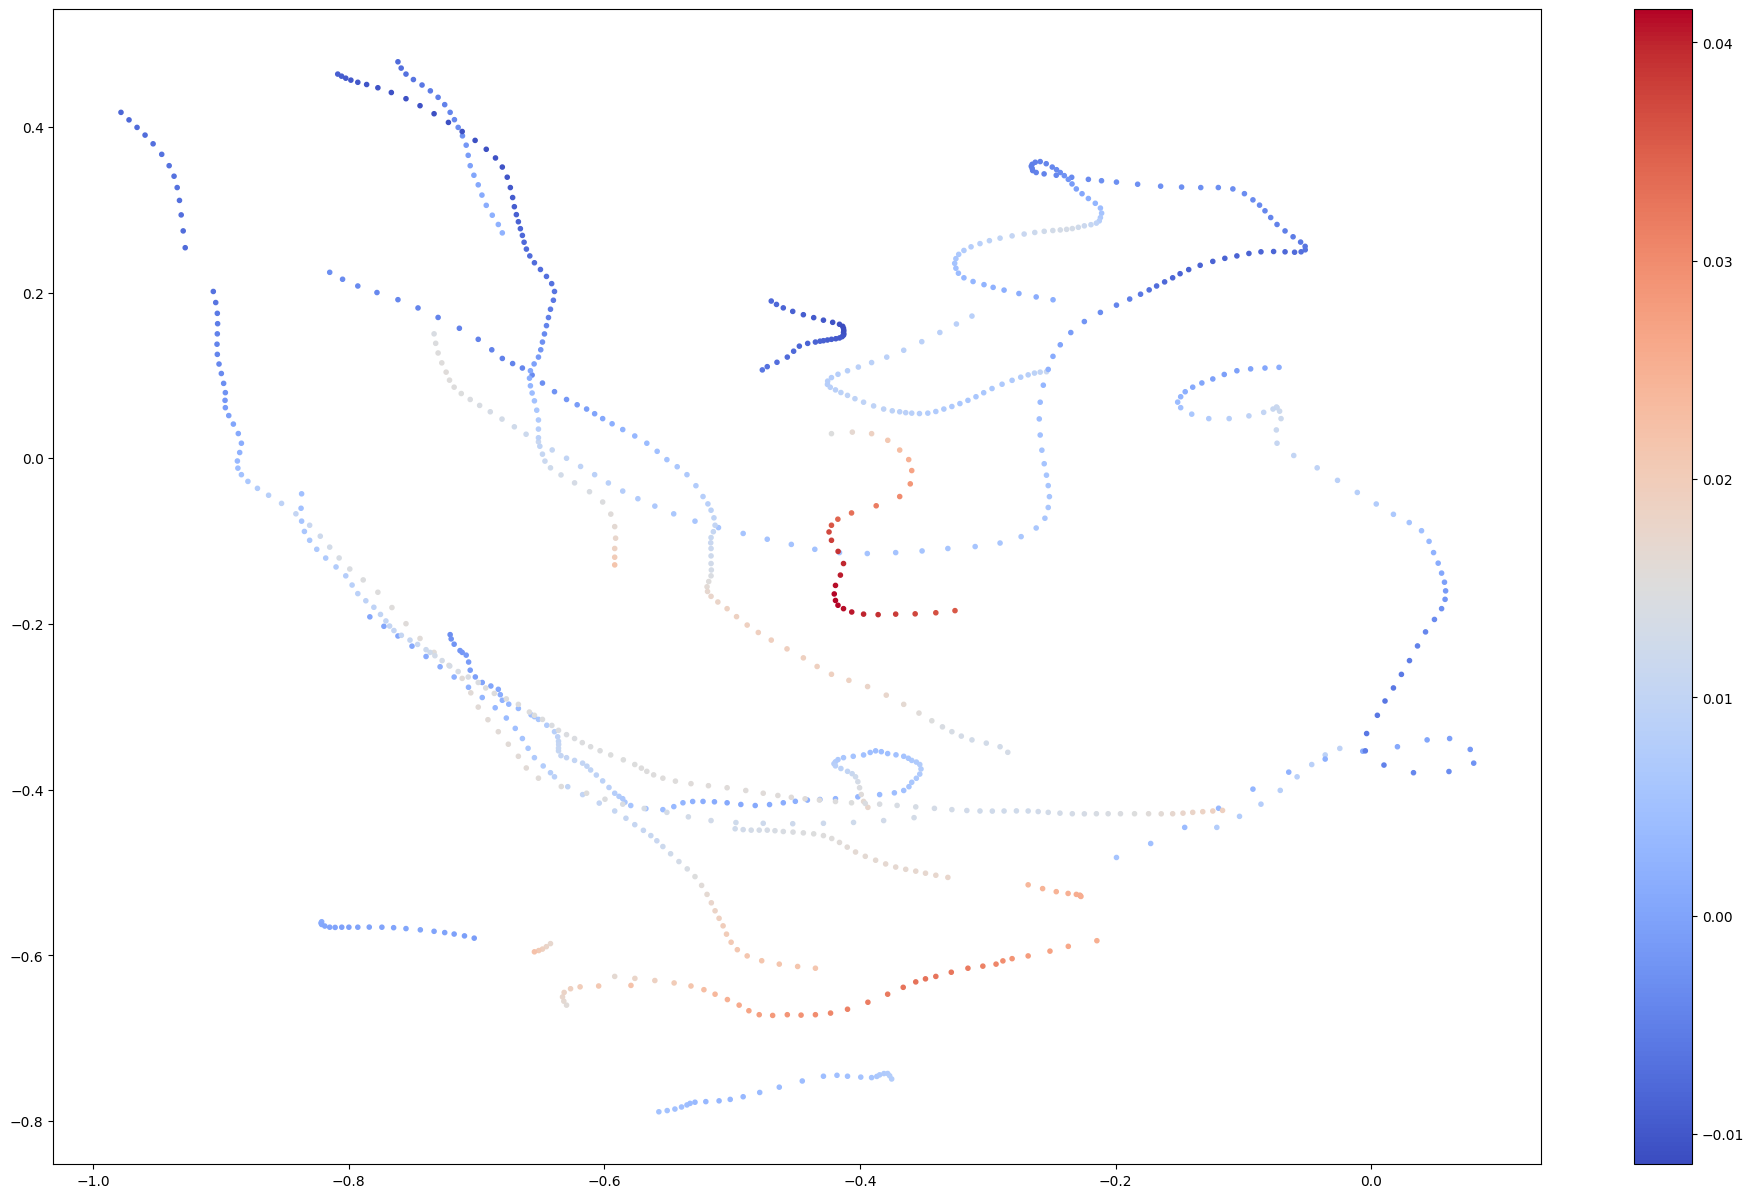

In [89]:
fig, ax = plt.subplots()
fig.set_size_inches(24, 15)

idx = -1
evec_idx = 1

cmap = plt.cm.coolwarm

plt.scatter(test_dataset.data[:idx, 0, 0], test_dataset.data[:idx, 0, 1], marker=".", cmap=cmap, c = evec_right[:idx, evec_idx])
plt.colorbar()

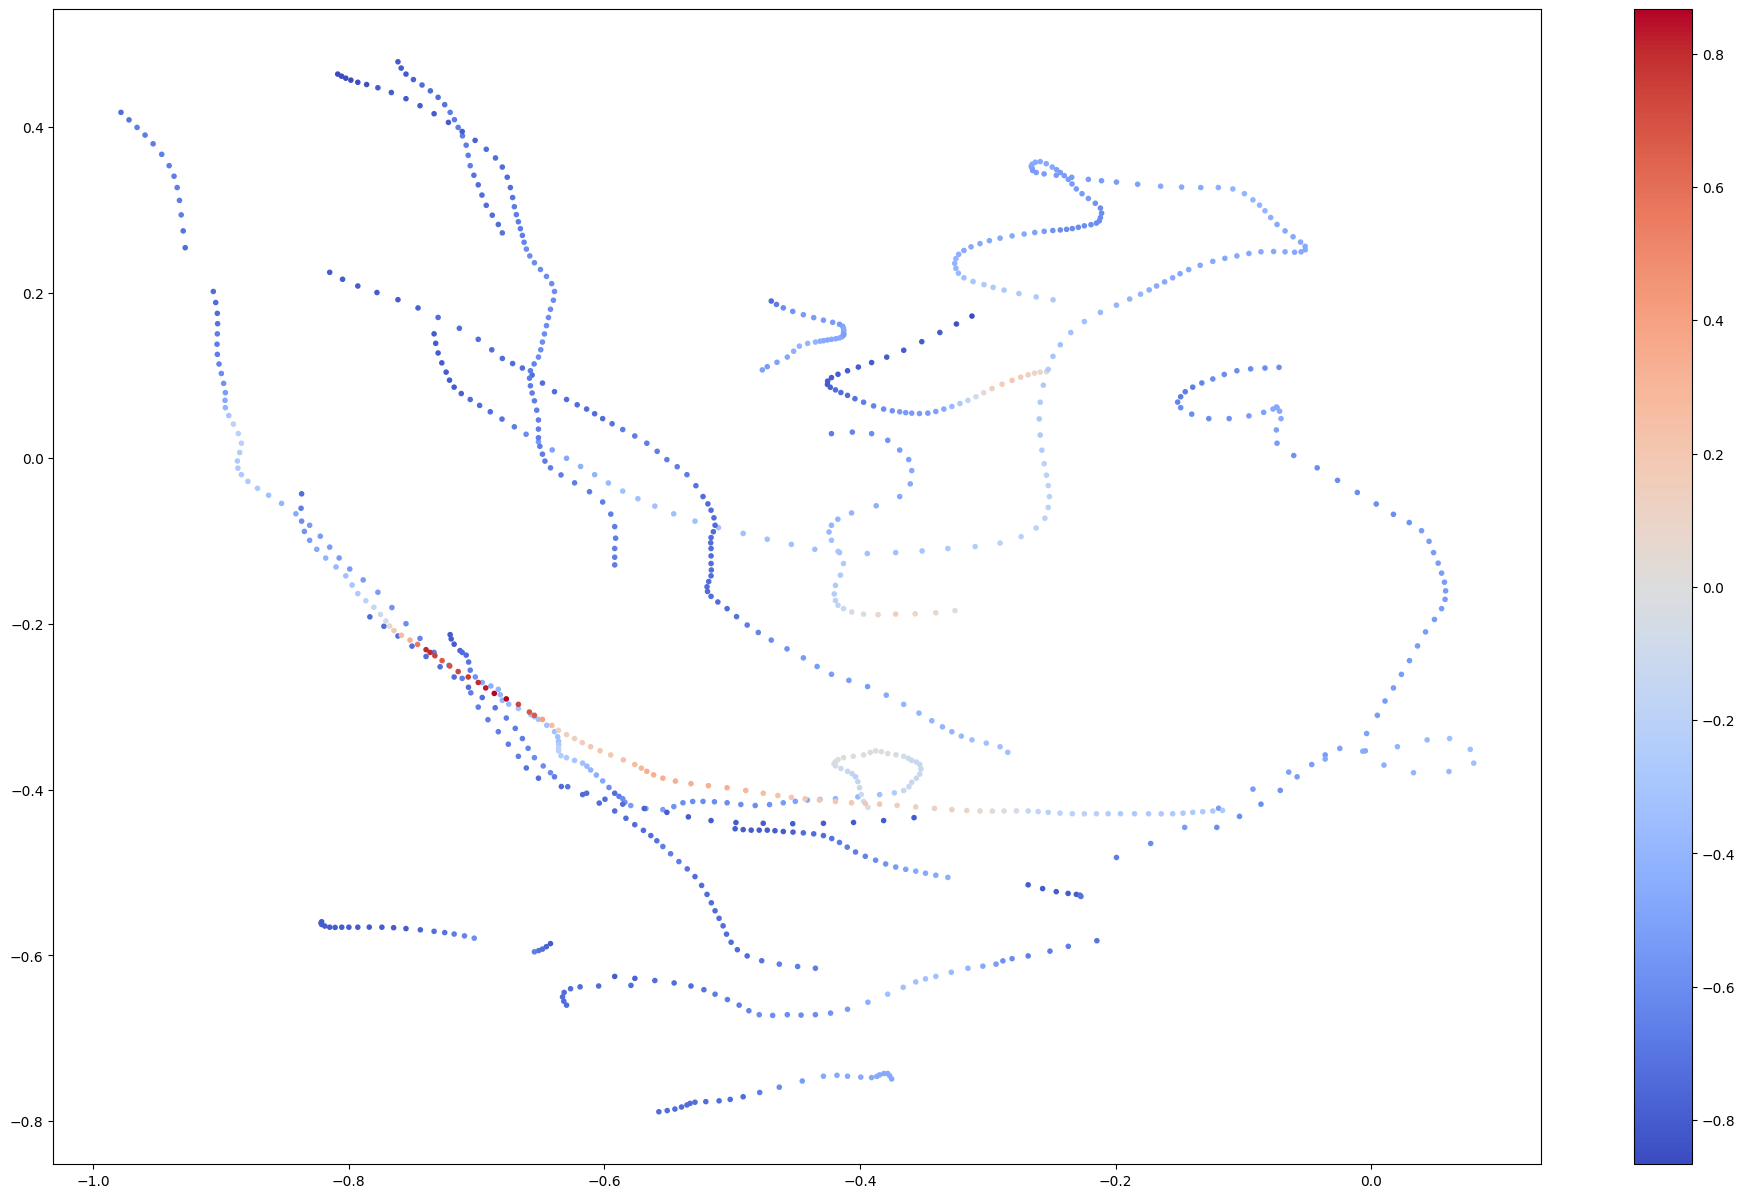

In [88]:
fig, ax = plt.subplots()
fig.set_size_inches(24, 15)

idx = -1

cmap = plt.cm.coolwarm

plt.scatter(test_dataset.data[:idx, 0, 0], test_dataset.data[:idx, 0, 1], marker=".", cmap=cmap, c = test_dataset.data[:idx, 0, 2])
plt.colorbar()